In [1]:
%reset

from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join, isdir
import math

pre_processed_dir = './Pre-processed data'

processed_files = [file for file in listdir(pre_processed_dir) if (isfile(join(pre_processed_dir, file))) and (file != 'NUM_STATIONS.txt')]

processed_files.sort()         #Will sort according to the date just in case it is not already sorted

print("---------------------Pre-Processed files---------------------")
print(processed_files)
print("-------------------------------------------------------------")

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
---------------------Pre-Processed files---------------------
['20150401.txt', '20150501.txt', '20150602.txt', '20150701.txt', '20150801.txt', '20150829.txt', '20150926.txt', '20151031.txt', '20151128.txt', '20160109.txt', '20160130.txt', '20160227.txt', '20160402.txt', '20160430.txt', '20160528.txt', '20160630.txt', '20160730.txt', '20160827.txt', '20160930.txt', '20161028.txt', '20161126.txt', '20161224.txt', '20170128.txt', '20170225.txt', '20170401.txt', '20170429.txt', '20170531.txt', '20170701.txt', '20170729.txt', '20170831.txt', '20171005.txt', '20171031.txt', '20171130.txt', '20171222.txt', '20180131.txt', '20180228.txt', '20180330.txt', '20180427.txt', '20180531.txt', '20180629.txt', '20180801.txt', '20180831.txt', '20180930.txt', '20181031.txt', '20181130.txt', '20181231.txt', '20190131.txt', '20190228.txt', '20190331.txt', '20190430.txt', '20190529.txt', '20190628.txt', '20190801.txt', '20190830.txt', '20191001

In [2]:
def condense_TRX_info(all_df):
    all_df = all_df.drop(['ANT_TYPE', 'BW_UNIT'], axis = 1)    #Not using these columns.....unit is Mega for all
    
    all_df = all_df.groupby(['BS_ID','DoS','OPR_NAME','System','FDD_BW','TDD_BW'])[['TRX_ID']].count()
    all_df = all_df.reset_index(level=['BS_ID','DoS','OPR_NAME','System','FDD_BW','TDD_BW'])
    all_df = all_df.rename(columns={'TRX_ID': 'NUM_TRX'})
    return all_df

In [3]:
def create_BS_type_tech_mapping(all_df): #Integrated or RRH based Base Station #Also, which technology each station have
    station_systems_df = all_df[['BS_ID', 'System']].drop_duplicates(keep='first')
    #station_systems_df['Generations'] = all_df['System'].str.split(' ').str.get(0)
    
    station_systems_df['Generations'] = np.where(station_systems_df['System'] != '5G NR 3500',
                                                 station_systems_df['System'].str.split(' ').str.get(0),
                                                 station_systems_df['System'])
    station_systems_df = station_systems_df.drop(['System'], axis = 1)
    station_systems_df = station_systems_df.drop_duplicates(keep='first')
    groups = station_systems_df.groupby('BS_ID')['Generations'].apply(list)
    groups_keys = groups.keys()
    
    dictionary_type = {}
    dictionary_tech = {}
    
    dictionary_highest_tech = {}
    
    for key in groups_keys:
        systems = groups[key]
        if set(systems) == set(['GSM']):
            dictionary_type[key] = 'I'
            dictionary_tech[key] = '2G'
            dictionary_highest_tech[key] = 'H_2G'
        elif set(systems) == set(['UMTS']):
            dictionary_type[key] = 'I'
            dictionary_tech[key] = '3G'
            dictionary_highest_tech[key] = 'H_3G'
        elif set(systems) == set(['LTE']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '4G'
            dictionary_highest_tech[key] = 'H_4G'
        elif set(systems) == set(['5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
            
            
        elif set(systems) == set(['GSM', 'UMTS']):
            dictionary_type[key] = 'I'
            dictionary_tech[key] = '2G/3G'
            dictionary_highest_tech[key] = 'H_3G'
        elif set(systems) == set(['GSM', 'UMTS', 'LTE']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/3G/4G'
            dictionary_highest_tech[key] = 'H_4G'
            
        elif set(systems) == set(['GSM', 'UMTS', 'LTE', '5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/3G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['GSM', 'UMTS', 'LTE', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/3G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
        elif set(systems) == set(['GSM', 'UMTS', 'LTE', '5G', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/3G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
            
        elif set(systems) == set(['UMTS', 'LTE']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '3G/4G'
            dictionary_highest_tech[key] = 'H_4G'
            
        elif set(systems) == set(['UMTS', 'LTE', '5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '3G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['UMTS', 'LTE', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '3G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
        elif set(systems) == set(['UMTS', 'LTE', '5G', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '3G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
            
            
        elif set(systems) == set(['LTE', '5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '4G/5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['LTE', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
        elif set(systems) == set(['LTE', '5G', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
            
        elif set(systems) == set(['GSM', 'LTE']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/4G'
            dictionary_highest_tech[key] = 'H_4G'
            
        elif set(systems) == set(['GSM', '5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['GSM', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
        elif set(systems) == set(['GSM', '5G', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
            
        elif set(systems) == set(['GSM', 'LTE', '5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['GSM', 'LTE', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
        elif set(systems) == set(['GSM', 'LTE', '5G', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'           
            
        elif set(systems) == set(['GSM', 'UMTS', '5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/3G/5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['GSM', 'UMTS', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/3G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500' 
        elif set(systems) == set(['GSM', 'UMTS', '5G', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/3G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500' 
            
        elif set(systems) == set(['UMTS', '5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '3G/5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['UMTS', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '3G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500' 
        elif set(systems) == set(['UMTS', '5G','5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '3G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500' 
    
    return (dictionary_type, dictionary_tech, dictionary_highest_tech)

In [4]:
def add_pw_cons_col(row, current_date):     #This function includes our assumptions related to power consumption.
    num_trx = row['NUM_TRX']
    num_mimo_antenna = 1
    
    systems_mimo_2x2 = ['LTE 700', 'LTE 800','5G NR 700']                                #'5G NR 700'
    systems_mimo_4x4 = ['LTE 1800', 'LTE 2100', 'LTE 2600','5G NR 2100']                 #'5G NR 2100'
    
    if row['System'] in systems_mimo_2x2:
        num_mimo_antenna = 2
    elif row['System'] in systems_mimo_4x4:
        num_mimo_antenna = 4
        
    BS_type = row['BS_TYPE']
    TRX_tech = row['System']
    FDD_DL_BW = float(row['FDD_BW'])
    TDD_BW = float(row['TDD_BW'])
    Date_of_Service = row['DoS']
    
    return num_trx * num_mimo_antenna * pw_models(Date_of_Service, BS_type, TRX_tech, FDD_DL_BW, TDD_BW, current_date)

In [5]:
def pw_models(Date_of_Service, BS_type, TRX_tech, FDD_DL_BW, TDD_BW, current_date): 
    
    load = 0.3                                           #Average load value to be multiplied with Pmax
    
    if TRX_tech != '5G NR 3500':           #If not 5G NR 3500 - #From AUER paper from 2011. This also cited in Lopez 2022
        P_max = 0
        
        #From Golard et al. (2022)
        #Based on DL BW (4 W per 1 MHz)
        P_max = FDD_DL_BW * 4
        
        if (FDD_DL_BW == 0):               #DL BW for TDD would be 0.
            P_max = TDD_BW * (2/3) * 4     #(2/3 * 4) W per 1 MHz

        #---------------------LOAD---------------------#
        P_max = P_max * load                                 #At 30 % load
        #-------------------------------------------------#

        sigma_feed = 0.5  #Mentioned in db in the paper but converted in Watts

        eta_PA = 0.311
        P_RF = 12.9
        P_BB = 29.6
        sigma_DC = 0.075
        sigma_cool = 0.1
        sigma_MS = 0.09

        if BS_type == 'RRH':
            sigma_cool = 0
            sigma_feed = 0.2                                #1 dB loss        
        #------------------------Performance Improvements with time------------------------#
        dos_bs_year = (datetime.strptime(Date_of_Service, '%d/%m/%Y')).year    #Year when the BS came into service
        
        replace_period = 8                                                     #In years
        
        current_year = current_date.year
        
        BS_equip_year_last_updated = current_year - ((current_year - dos_bs_year) % replace_period)
                
        model_year = (datetime(2011, 1, 1)).year                               #Earth Model Year
        
        performance_diff_years = BS_equip_year_last_updated - model_year       #The values need to be updated for this many years
        
        for i in range(performance_diff_years):
            #Per year improvement of 2% in PA
            eta_PA = eta_PA * 1.02                   
            
            #Moore's law for the analog and digital circuitary. Applied every two years
            if ((i % 2 == 0) and (i != 0)):
                P_RF = P_RF / math.sqrt(2)         #Analog front-end
                P_BB = P_BB / 2                    #Digital Baseband. Every 2 years BB power gets halved.
        
        #----------------------------------------------------------------------------------#
        total_PA = P_max / ((eta_PA)*(1 - sigma_feed))
        TRX_PW_consumption = (total_PA + P_RF + P_BB) / ((1 - sigma_DC)*(1 - sigma_MS)*(1 - sigma_cool))
        
    else:                     #Case of 5G NR 3500 - Different Model from Tombaz et al. (2015) with no scaling
        P_max = 240           #This value is from Han et al. (2020)
        N_TRX = 64
        P_c = 1
        P_Base = 260
        eta_PA = 0.25
        #------------------------------------------------------------------------------------------------#
        
        P_Tx = (load * P_max)/eta_PA
        TRX_PW_consumption = P_Tx + (N_TRX * P_c) + P_Base         
        
    return TRX_PW_consumption

In [6]:
def pw_per_opr(all_df, total_pw_main_opr, total_pw_ORANGE, total_pw_SFR, total_pw_BT, total_pw_FREE,
               BS_avg_pw_main_opr, BS_avg_pw_ORANGE, BS_avg_pw_SFR, BS_avg_pw_BT, BS_avg_pw_FREE):
    divider = 1000000         #For MW
    
    total_pw = (all_df["Calculated_Power"].sum())/divider
    total_pw_main_opr.append(total_pw)
    
    temp_df = all_df[['OPR_NAME', "Calculated_Power"]]
    opr_groups = temp_df.groupby('OPR_NAME')["Calculated_Power"].sum()
    
    ORANGE_pw = opr_groups['ORANGE']/divider
    SFR_pw = opr_groups['SFR']/divider
    BT_pw = opr_groups['BOUYGUES TELECOM']/divider
    FREE_pw = opr_groups['FREE MOBILE']/divider
    
    total_pw_ORANGE.append(ORANGE_pw)
    total_pw_SFR.append(SFR_pw)
    total_pw_BT.append(BT_pw)
    total_pw_FREE.append(FREE_pw)
    
    temp_df = all_df[['BS_ID', 'OPR_NAME']].drop_duplicates(keep='first')
    opr_groups = temp_df.groupby('OPR_NAME')['BS_ID'].count()
    
    total_BS_num = opr_groups['ORANGE'] + opr_groups['SFR'] + opr_groups['BOUYGUES TELECOM'] + opr_groups['FREE MOBILE']
    
    multiplier = 1000         #For converting from MW to KW
    
    BS_avg_pw_main_opr.append((total_pw / total_BS_num) * multiplier)
    BS_avg_pw_ORANGE.append((ORANGE_pw / opr_groups['ORANGE']) * multiplier)
    BS_avg_pw_SFR.append((SFR_pw / opr_groups['SFR']) * multiplier)
    BS_avg_pw_BT.append((BT_pw / opr_groups['BOUYGUES TELECOM']) * multiplier)
    BS_avg_pw_FREE.append((FREE_pw / opr_groups['FREE MOBILE']) * multiplier)
    
    return

In [7]:
def pw_per_tech(all_df, total_BS_pw_2G, total_BS_pw_3G, total_BS_pw_4G, total_BS_pw_5G, total_BS_pw_2G_3G,
               total_BS_pw_2G_3G_4G, total_BS_pw_2G_3G_4G_5G, total_BS_pw_3G_4G, total_BS_pw_3G_4G_5G,
               total_BS_pw_4G_5G, total_BS_pw_2G_4G, total_BS_pw_2G_5G, total_BS_pw_2G_4G_5G, total_BS_pw_2G_3G_5G,
                total_BS_pw_3G_5G):
       
    divider = 1000000         #For MW
    
    temp_df = all_df[['BS_TECH', "Calculated_Power"]]
    tech_groups = temp_df.groupby('BS_TECH')["Calculated_Power"].sum()
    
    pw_2G = tech_groups['2G']/divider
    pw_3G = tech_groups['3G']/divider
    pw_4G = tech_groups['4G']/divider
    pw_5G = 0
    pw_2G_3G = tech_groups['2G/3G']/divider
    pw_2G_3G_4G = tech_groups['2G/3G/4G']/divider
    pw_2G_3G_4G_5G = 0
    pw_3G_4G = tech_groups['3G/4G']/divider
    pw_3G_4G_5G = 0
    pw_4G_5G = 0
    
    pw_2G_4G = 0
    pw_2G_5G = 0
    pw_2G_4G_5G = 0
    pw_2G_3G_5G = 0
    pw_3G_5G = 0    
    
    total_BS_pw_2G.append(pw_2G)
    total_BS_pw_3G.append(pw_3G)
    total_BS_pw_4G.append(pw_4G)
    #---if else for cases when there were no 5G BSs---#
    if '5G' in tech_groups.keys():
        pw_5G = tech_groups['5G']/divider
        total_BS_pw_5G.append(pw_5G)
    else:
        total_BS_pw_5G.append(0)
        
    total_BS_pw_2G_3G.append(pw_2G_3G)
    total_BS_pw_2G_3G_4G.append(pw_2G_3G_4G)
    
    if '2G/3G/4G/5G' in tech_groups.keys():
        pw_2G_3G_4G_5G = tech_groups['2G/3G/4G/5G']/divider
        total_BS_pw_2G_3G_4G_5G.append(pw_2G_3G_4G_5G)
    else:
        total_BS_pw_2G_3G_4G_5G.append(0)
        
    total_BS_pw_3G_4G.append(pw_3G_4G)
    
    if '3G/4G/5G' in tech_groups.keys():
        pw_3G_4G_5G = tech_groups['3G/4G/5G']/divider
        total_BS_pw_3G_4G_5G.append(pw_3G_4G_5G)
    else:
        total_BS_pw_3G_4G_5G.append(0)
        
    if '4G/5G' in tech_groups.keys():
        pw_4G_5G = tech_groups['4G/5G']/divider
        total_BS_pw_4G_5G.append(pw_4G_5G)
    else:
        total_BS_pw_4G_5G.append(0)

    if '2G/4G' in tech_groups.keys():
        pw_2G_4G = tech_groups['2G/4G']/divider
        total_BS_pw_2G_4G.append(pw_2G_4G)
    else:
        total_BS_pw_2G_4G.append(0)
        
    if '2G/5G' in tech_groups.keys():
        pw_2G_5G = tech_groups['2G/5G']/divider
        total_BS_pw_2G_5G.append(pw_2G_5G)
    else:
        total_BS_pw_2G_5G.append(0)
        
    if '2G/4G/5G' in tech_groups.keys():
        pw_2G_4G_5G = tech_groups['2G/4G/5G']/divider
        total_BS_pw_2G_4G_5G.append(pw_2G_4G_5G)
    else:
        total_BS_pw_2G_4G_5G.append(0)
        
    if '2G/3G/5G' in tech_groups.keys():
        pw_2G_3G_5G = tech_groups['2G/3G/5G']/divider
        total_BS_pw_2G_3G_5G.append(pw_2G_3G_5G)
    else:
        total_BS_pw_2G_3G_5G.append(0)
    
    if '3G/5G' in tech_groups.keys():
        pw_3G_5G = tech_groups['3G/5G']/divider
        total_BS_pw_3G_5G.append(pw_3G_5G)
    else:
        total_BS_pw_3G_5G.append(0)
        
    return

In [8]:
def avg_pw_per_freq_num(all_df, BS_avg_pw_1_freq_sys, BS_avg_pw_2_freq_sys, BS_avg_pw_3_freq_sys, BS_avg_pw_4_freq_sys,
                       BS_avg_pw_5_freq_sys, BS_avg_pw_6_freq_sys, BS_avg_pw_7_freq_sys, BS_avg_pw_8_freq_sys, BS_avg_pw_9_freq_sys,
                       BS_avg_pw_10_freq_sys, BS_avg_pw_11_freq_sys):
    temp_df = all_df[['BS_ID', 'System', "Calculated_Power"]]
    groups_BS = temp_df.groupby('BS_ID').aggregate({"System": "count", "Calculated_Power": "sum"})
    temp_df = groups_BS.reset_index(level=['BS_ID'])    #one row have the BS_ID, System Count (Only unique count) and Total Power
    
    groups_sys_count = temp_df.groupby('System').aggregate({"BS_ID": "count", "Calculated_Power": "sum"})
    temp_df = groups_sys_count.reset_index(level=['System'])
    #print(temp_df)
    
    pw_freq_1 = temp_df.loc[temp_df['System'] == 1]["Calculated_Power"] / temp_df.loc[temp_df['System'] == 1]['BS_ID']
    pw_freq_2 = temp_df.loc[temp_df['System'] == 2]["Calculated_Power"] / temp_df.loc[temp_df['System'] == 2]['BS_ID']
    pw_freq_3 = temp_df.loc[temp_df['System'] == 3]["Calculated_Power"] / temp_df.loc[temp_df['System'] == 3]['BS_ID']
    pw_freq_4 = temp_df.loc[temp_df['System'] == 4]["Calculated_Power"] / temp_df.loc[temp_df['System'] == 4]['BS_ID']
    pw_freq_5 = temp_df.loc[temp_df['System'] == 5]["Calculated_Power"] / temp_df.loc[temp_df['System'] == 5]['BS_ID']
    pw_freq_6 = temp_df.loc[temp_df['System'] == 6]["Calculated_Power"] / temp_df.loc[temp_df['System'] == 6]['BS_ID']
    pw_freq_7 = temp_df.loc[temp_df['System'] == 7]["Calculated_Power"] / temp_df.loc[temp_df['System'] == 7]['BS_ID']
    pw_freq_8 = temp_df.loc[temp_df['System'] == 8]["Calculated_Power"] / temp_df.loc[temp_df['System'] == 8]['BS_ID']
    pw_freq_9 = temp_df.loc[temp_df['System'] == 9]["Calculated_Power"] / temp_df.loc[temp_df['System'] == 9]['BS_ID']
    pw_freq_10 = temp_df.loc[temp_df['System'] == 10]["Calculated_Power"] / temp_df.loc[temp_df['System'] == 10]['BS_ID']
    pw_freq_11 = temp_df.loc[temp_df['System'] == 11]["Calculated_Power"] / temp_df.loc[temp_df['System'] == 11]['BS_ID']
    
    divider = 1000    #For kW
    
    BS_avg_pw_1_freq_sys.append(pw_freq_1 / divider)
    BS_avg_pw_2_freq_sys.append(pw_freq_2 / divider)
    BS_avg_pw_3_freq_sys.append(pw_freq_3 / divider)
    BS_avg_pw_4_freq_sys.append(pw_freq_4 / divider)
    BS_avg_pw_5_freq_sys.append(pw_freq_5 / divider)
    BS_avg_pw_6_freq_sys.append(pw_freq_6 / divider)
    BS_avg_pw_7_freq_sys.append(pw_freq_7 / divider)
    BS_avg_pw_8_freq_sys.append(pw_freq_8 / divider)
    BS_avg_pw_9_freq_sys.append(pw_freq_9 / divider)
    BS_avg_pw_10_freq_sys.append(pw_freq_10 / divider)
    BS_avg_pw_11_freq_sys.append(pw_freq_11 / divider)
    
    return

In [9]:
def avg_pw_per_highest_tech(all_df, BS_avg_pw_H_2G, BS_avg_pw_H_3G, BS_avg_pw_H_4G, BS_avg_pw_H_5G, BS_avg_pw_H_5G_3500):
    temp_df = all_df[['BS_H_TECH', "Calculated_Power"]]
    tech_groups = temp_df.groupby('BS_H_TECH')["Calculated_Power"].sum()
    
    divider = 1000000                                           #For MW
    pw_H_2G = tech_groups['H_2G']/divider
    pw_H_3G = tech_groups['H_3G']/divider
    pw_H_4G = tech_groups['H_4G']/divider
    pw_H_5G = 0
    pw_H_5G_3500 = 0
    
    #---if else for cases when there were no 5G BSs---#
    if 'H_5G' in tech_groups.keys():
        pw_H_5G = tech_groups['H_5G']/divider
    if 'H_5G_3500' in tech_groups.keys():
        pw_H_5G_3500 = tech_groups['H_5G_3500']/divider
        
    
    temp_df = all_df[['BS_ID', 'BS_H_TECH']].drop_duplicates(keep='first')
    tech_groups = temp_df.groupby('BS_H_TECH')['BS_ID'].count()
    
    multiplier = 1000         #For converting from MW to KW     
    
    BS_avg_pw_H_2G.append((pw_H_2G/tech_groups['H_2G']) * multiplier)
    BS_avg_pw_H_3G.append((pw_H_3G/tech_groups['H_3G']) * multiplier)
    BS_avg_pw_H_4G.append((pw_H_4G/tech_groups['H_4G']) * multiplier)
    #BS_avg_pw_H_5G.append((pw_5G/tech_groups['H_5G']) * multiplier)
    #BS_avg_pw_H_5G_3500.append((pw_H_5G_3500/tech_groups['H_5G_3500']) * multiplier)
    
    if 'H_5G' in tech_groups.keys():
        BS_avg_pw_H_5G.append((pw_H_5G/tech_groups['H_5G']) * multiplier)
    else:
        BS_avg_pw_H_5G.append(0)
        
    if 'H_5G_3500' in tech_groups.keys():
        BS_avg_pw_H_5G_3500.append((pw_H_5G_3500/tech_groups['H_5G_3500']) * multiplier)
    else:
        BS_avg_pw_H_5G_3500.append(0)
    
    return

In [10]:
def plot_pw_per_tech_timeseries(dates, total_pw_main_opr, total_BS_pw_2G, total_BS_pw_3G, total_BS_pw_4G, total_BS_pw_5G,
                            total_BS_pw_2G_3G, total_BS_pw_2G_3G_4G, total_BS_pw_2G_3G_4G_5G, total_BS_pw_3G_4G, 
                            total_BS_pw_3G_4G_5G, total_BS_pw_4G_5G, total_BS_pw_2G_4G, total_BS_pw_2G_5G, 
                            total_BS_pw_2G_4G_5G, total_BS_pw_2G_3G_5G, total_BS_pw_3G_5G):
    plt.plot(dates, total_pw_main_opr, color='purple', label='All Generations', linewidth=5)

    plt.plot(dates, total_BS_pw_2G, color='green', label='2G', linewidth=5)

    plt.plot(dates, total_BS_pw_3G, color='orange', label='3G', linewidth=5)

    plt.plot(dates, total_BS_pw_2G_3G, color='yellow', label='2G/3G', linewidth=5)

    plt.plot(dates, total_BS_pw_2G_3G_4G, color='pink', label='2G/3G/4G', linewidth=5)

    plt.plot(dates, total_BS_pw_2G_3G_4G_5G, color='brown', label='2G/3G/4G/5G', linewidth=5)

    plt.plot(dates, total_BS_pw_3G_4G, color='black', label='3G/4G', linewidth=5)

    plt.plot(dates, total_BS_pw_3G_4G_5G, color='cyan', label='3G/4G/5G', linewidth=5)
    
    plt.axvline(x = datetime(2020, 12, 1), color = 'b', linestyle='dashed')

    plt.legend(fontsize=21)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.ylabel("Total BS Power Consumption (MW)", fontsize=24)

    plt.ylim(ymin = 0)
    # Save Image
    plt.savefig('./Graphs/BSs_PW_by_Technology.pdf')
    # Show graphic
    plt.show()
    
    return

In [11]:
def plot_avg_pw_per_BS_freq_sys_num_monthwise(dates, BS_avg_pw_1_freq_sys, BS_avg_pw_2_freq_sys, BS_avg_pw_3_freq_sys, 
                                                BS_avg_pw_4_freq_sys, BS_avg_pw_5_freq_sys, BS_avg_pw_6_freq_sys, 
                                                BS_avg_pw_7_freq_sys, BS_avg_pw_8_freq_sys, BS_avg_pw_9_freq_sys, 
                                                BS_avg_pw_10_freq_sys, BS_avg_pw_11_freq_sys):
    
    for i in range(len(BS_avg_pw_9_freq_sys)):
        if BS_avg_pw_9_freq_sys[i].empty:
            BS_avg_pw_9_freq_sys[i] = pd.Series(np.array([0]))          #Adding a series with one item which is zero to keep the format consistent
        if BS_avg_pw_10_freq_sys[i].empty:
            BS_avg_pw_10_freq_sys[i] = pd.Series(np.array([0]))
        if BS_avg_pw_11_freq_sys[i].empty:
            BS_avg_pw_11_freq_sys[i] = pd.Series(np.array([0]))

    last_ind = len(BS_avg_pw_1_freq_sys) - 1
    for i in range(len(dates)):
        if ((dates[i].year == 2022) and (dates[i].month == 9)):
            last_ind = i
    
    pw_values = [BS_avg_pw_1_freq_sys[last_ind].item(), BS_avg_pw_2_freq_sys[last_ind].item(), BS_avg_pw_3_freq_sys[last_ind].item(), BS_avg_pw_4_freq_sys[last_ind].item(), BS_avg_pw_5_freq_sys[last_ind].item(), BS_avg_pw_6_freq_sys[last_ind].item(), BS_avg_pw_7_freq_sys[last_ind].item(), BS_avg_pw_8_freq_sys[last_ind].item(), BS_avg_pw_9_freq_sys[last_ind].item(), BS_avg_pw_10_freq_sys[last_ind].item(), BS_avg_pw_11_freq_sys[last_ind].item()]
    labels = ['1','2','3','4','5','6','7','8','9','10','11']
    
    # creating the bar plot
    plt.bar(labels, pw_values, color='blue', width = 0.6)
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.ylabel("Average BS Power Consumption (KW)", fontsize=24)
    plt.xlabel('Number of Frequencies per BS', fontsize=24)

    plt.ylim(ymin = 0)
    # Save Image
    plt.savefig('./Graphs/BSs_AVG_PW_by_Freq_Sys_Num_Monthwise.pdf')
    # Show graphic
    plt.show()
    
    return

In [12]:
def plot_avg_pw_per_highest_BS_tech_monthwise(dates, BS_avg_pw_main_opr, BS_avg_pw_H_2G, BS_avg_pw_H_3G, BS_avg_pw_H_4G, BS_avg_pw_H_5G, BS_avg_pw_H_5G_3500):
    last_ind = len(BS_avg_pw_main_opr) - 1
    for i in range(len(dates)):
        if ((dates[i].year == 2022) and (dates[i].month == 9)):
            last_ind = i
        
    
    pw_values = [BS_avg_pw_main_opr[last_ind], BS_avg_pw_H_2G[last_ind], BS_avg_pw_H_3G[last_ind], BS_avg_pw_H_4G[last_ind], BS_avg_pw_H_5G[last_ind], BS_avg_pw_H_5G_3500[last_ind]]
    labels = ["All Generations", "2G", "3G", "4G", "5G\n(700 &\n2100 MHz)", "5G\n(3500 MHz)"]
    
    # creating the bar plot
    plt.bar(labels, pw_values, color='lightcoral', width = 0.8)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.ylabel("Average BS Power Consumption (KW)", fontsize=24)
    plt.xlabel('Highest BS Technology', fontsize=24)
    #plt.title('Average BS Power Consumption by Technology at 30% load in France* (August 2022)', fontsize=16)

    plt.ylim(ymin = 0)
    # Save Image
    plt.savefig('./Graphs/BSs_AVG_PW_by_Highest_Tech_MonthWise.pdf')
    # Show graphic
    plt.show()
    
    return

In [13]:
def CAGR(dates, total_pw_main_opr, BS_avg_pw_main_opr):
    #---------------------------FOR TOTAL---------------------------#
    final_val = total_pw_main_opr[len(total_pw_main_opr) - 1]
    
    initial_val = total_pw_main_opr[0]
    time_months = len(dates) - 1                    #minus 1 because the first date is the starting point
    time_years = time_months / 12
    
    cagr = ((final_val/initial_val)**(1/time_years)) - 1
    print ('BS Total Power CAGR:', cagr)
    
    #After 5G
    start_date_5G_index = dates.index(datetime(2020, 10, 30))
    initial_val_5G = total_pw_main_opr[start_date_5G_index]
    
    time_months = (len(dates) - start_date_5G_index) - 1           #minus 1 because the first date is the starting point
    time_years = time_months / 12
    
    cagr_5G = ((final_val/initial_val_5G)**(1/time_years)) - 1
    print ('BS Total Power CAGR after 5G:', cagr_5G)
    
    #---------------------------FOR Average---------------------------#

    
    final_val = BS_avg_pw_main_opr[len(BS_avg_pw_main_opr) - 1]
    
    initial_val = BS_avg_pw_main_opr[0]
    time_months = len(dates) - 1                    #minus 1 because the first date is the starting point
    time_years = time_months / 12
    
    cagr = ((final_val/initial_val)**(1/time_years)) - 1
    print ('BS Average Power CAGR:', cagr)
    
    #After 5G
    start_date_5G_index = dates.index(datetime(2020, 10, 30))
    initial_val_5G = BS_avg_pw_main_opr[start_date_5G_index]
    
    time_months = (len(dates) - start_date_5G_index) - 1            #minus 1 because the first date is the starting point
    time_years = time_months / 12
    
    cagr_5G = ((final_val/initial_val_5G)**(1/time_years)) - 1
    print ('BS Average Power CAGR after 5G:', cagr_5G)
    print('--------------------------------------------------------')
    print('BS Average Power starting value:', BS_avg_pw_main_opr[0])
    print('BS Average Power ending value:', BS_avg_pw_main_opr[len(BS_avg_pw_main_opr) - 1])
    
    return

In [14]:
encoding_type = 'latin1'

dates = []

total_pw_main_opr = []

total_pw_SFR = []
total_pw_ORANGE = []
total_pw_BT = []
total_pw_FREE = []

#----Single type BSs only - Determined based on transceivers present on the base station----#
total_BS_pw_2G = []
total_BS_pw_3G = []
total_BS_pw_4G = []
total_BS_pw_5G = []
#----BSs running multiple technologies----#
total_BS_pw_2G_3G = []
total_BS_pw_2G_3G_4G = []
total_BS_pw_2G_3G_4G_5G = []
total_BS_pw_3G_4G = []
total_BS_pw_3G_4G_5G = []
total_BS_pw_4G_5G = []

total_BS_pw_2G_4G = []
total_BS_pw_2G_5G = []
total_BS_pw_2G_4G_5G = []
total_BS_pw_2G_3G_5G = []
total_BS_pw_3G_5G = []

#----Average Power Consumption per BS----#
BS_avg_pw_main_opr = []
BS_avg_pw_SFR = []
BS_avg_pw_ORANGE = []
BS_avg_pw_BT = []
BS_avg_pw_FREE = []

#----Average BS Power Consumption for each highest BS technology type----#
BS_avg_pw_H_2G = []
BS_avg_pw_H_3G = []
BS_avg_pw_H_4G = []
BS_avg_pw_H_5G = []            #Till 5G NR 700 & 5G NR 2100
BS_avg_pw_H_5G_3500 = []        
 

#----Average Power Consumption for each BS (based on the # of frequencies)----#
BS_avg_pw_1_freq_sys = []
BS_avg_pw_2_freq_sys = []
BS_avg_pw_3_freq_sys = []
BS_avg_pw_4_freq_sys = []
BS_avg_pw_5_freq_sys = []
BS_avg_pw_6_freq_sys = []
BS_avg_pw_7_freq_sys = []
BS_avg_pw_8_freq_sys = []
BS_avg_pw_9_freq_sys = []
BS_avg_pw_10_freq_sys = []
BS_avg_pw_11_freq_sys = []


plt.rcParams["figure.figsize"] = (12,12)        #Setting plot size

for file in processed_files:
    print('------------Currently Processing------------')
    print(file)
    print('--------------------------------------------')
    
    date = file.split('.')[0]
    dates.append(datetime.strptime(date, '%Y%m%d'))
    
    #-------------Reading the current preprocessed file-------------#
    all_df = pd.read_csv(join(pre_processed_dir, file), sep = ';', dtype=str, encoding = encoding_type)
    
    #------------Condensing data more by introducing a count column for TRX with exactly same characteristics------------#
    all_df = condense_TRX_info(all_df)
    
    #------------Creating three dictionaries------------#
    #------------One to know the BS type (integrated or RRH based) which will be used during power calc------------#
    #------------One to know the BS tech (2G, 3G, 2G/3G and so on)------------#
    #------------One to know the highest BS tech (2G, 3G(2G + 2G/3G), 4G(2G + 2G/3G + 2G/3G/4G + 2G/4G + 3G/4G) and so on)------------#
    BS_dicts = create_BS_type_tech_mapping(all_df)
    BS_type_dict = BS_dicts[0]
    BS_tech_dict = BS_dicts[1]
    BS_highest_tech_dict = BS_dicts[2]
    #------------Using the dicts to add columns in the main dataframe------------#
    all_df['BS_TYPE'] = all_df['BS_ID'].map(BS_type_dict)
    all_df['BS_TECH'] = all_df['BS_ID'].map(BS_tech_dict)
    all_df['BS_H_TECH'] = all_df['BS_ID'].map(BS_highest_tech_dict)
    
    #------------Adding a power consumption column-------------#
    all_df["Calculated_Power"] = all_df.apply(add_pw_cons_col, current_date = datetime.strptime(date, '%Y%m%d'), axis=1) #Calculating the power consumption for each row
    
    #------------Gathering power consumption stats for different groups------------#
    pw_per_opr(all_df, total_pw_main_opr, total_pw_ORANGE, total_pw_SFR, total_pw_BT, total_pw_FREE,
              BS_avg_pw_main_opr, BS_avg_pw_ORANGE, BS_avg_pw_SFR, BS_avg_pw_BT, BS_avg_pw_FREE)
    
    pw_per_tech(all_df, total_BS_pw_2G, total_BS_pw_3G, total_BS_pw_4G, total_BS_pw_5G, total_BS_pw_2G_3G,
               total_BS_pw_2G_3G_4G, total_BS_pw_2G_3G_4G_5G, total_BS_pw_3G_4G, total_BS_pw_3G_4G_5G,
               total_BS_pw_4G_5G, total_BS_pw_2G_4G, total_BS_pw_2G_5G, total_BS_pw_2G_4G_5G, total_BS_pw_2G_3G_5G,
                total_BS_pw_3G_5G)
    
    avg_pw_per_freq_num(all_df, BS_avg_pw_1_freq_sys, BS_avg_pw_2_freq_sys, BS_avg_pw_3_freq_sys, BS_avg_pw_4_freq_sys,
                       BS_avg_pw_5_freq_sys, BS_avg_pw_6_freq_sys, BS_avg_pw_7_freq_sys, BS_avg_pw_8_freq_sys, BS_avg_pw_9_freq_sys,
                       BS_avg_pw_10_freq_sys, BS_avg_pw_11_freq_sys)
    
    avg_pw_per_highest_tech(all_df, BS_avg_pw_H_2G, BS_avg_pw_H_3G, BS_avg_pw_H_4G, BS_avg_pw_H_5G, BS_avg_pw_H_5G_3500)

------------Currently Processing------------
20150401.txt
--------------------------------------------
------------Currently Processing------------
20150501.txt
--------------------------------------------
------------Currently Processing------------
20150602.txt
--------------------------------------------
------------Currently Processing------------
20150701.txt
--------------------------------------------
------------Currently Processing------------
20150801.txt
--------------------------------------------
------------Currently Processing------------
20150829.txt
--------------------------------------------
------------Currently Processing------------
20150926.txt
--------------------------------------------
------------Currently Processing------------
20151031.txt
--------------------------------------------
------------Currently Processing------------
20151128.txt
--------------------------------------------
------------Currently Processing------------
20160109.txt
---------------

------------Currently Processing------------
20211223.txt
--------------------------------------------
------------Currently Processing------------
20220131.txt
--------------------------------------------
------------Currently Processing------------
20220228.txt
--------------------------------------------
------------Currently Processing------------
20220331.txt
--------------------------------------------
------------Currently Processing------------
20220429.txt
--------------------------------------------
------------Currently Processing------------
20220531.txt
--------------------------------------------
------------Currently Processing------------
20220630.txt
--------------------------------------------
------------Currently Processing------------
20220729.txt
--------------------------------------------
------------Currently Processing------------
20220831.txt
--------------------------------------------
------------Currently Processing------------
20220930.txt
---------------

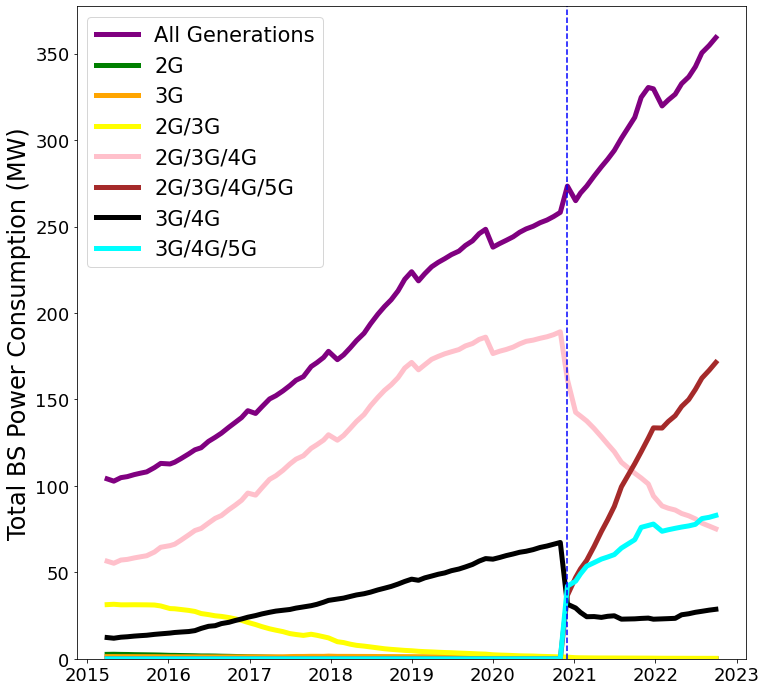

In [15]:
plot_pw_per_tech_timeseries(dates, total_pw_main_opr, total_BS_pw_2G, total_BS_pw_3G, total_BS_pw_4G, total_BS_pw_5G,
                            total_BS_pw_2G_3G, total_BS_pw_2G_3G_4G, total_BS_pw_2G_3G_4G_5G, total_BS_pw_3G_4G, 
                            total_BS_pw_3G_4G_5G, total_BS_pw_4G_5G, total_BS_pw_2G_4G, total_BS_pw_2G_5G, 
                            total_BS_pw_2G_4G_5G, total_BS_pw_2G_3G_5G, total_BS_pw_3G_5G)

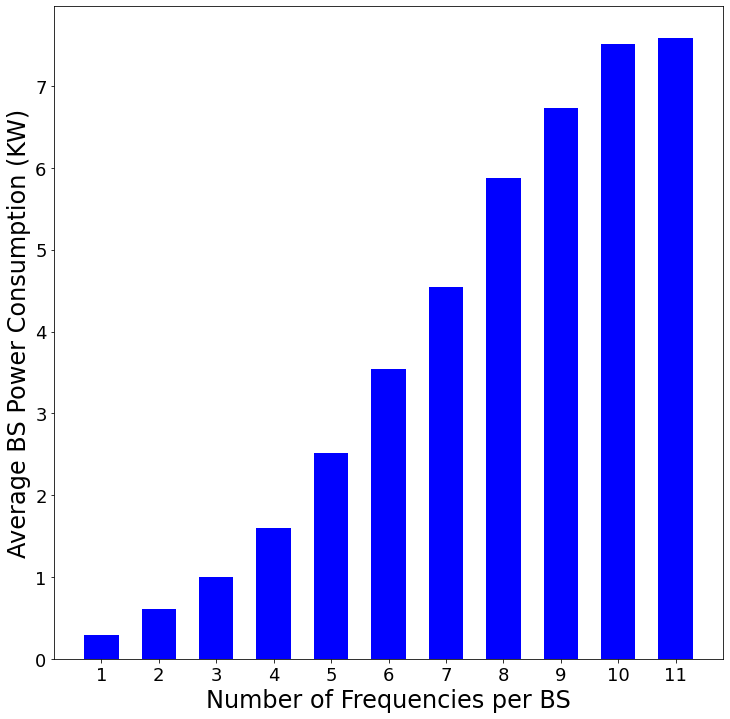

In [16]:
plot_avg_pw_per_BS_freq_sys_num_monthwise(dates, BS_avg_pw_1_freq_sys, BS_avg_pw_2_freq_sys, BS_avg_pw_3_freq_sys, 
                                                BS_avg_pw_4_freq_sys, BS_avg_pw_5_freq_sys, BS_avg_pw_6_freq_sys, 
                                                BS_avg_pw_7_freq_sys, BS_avg_pw_8_freq_sys, BS_avg_pw_9_freq_sys, 
                                                BS_avg_pw_10_freq_sys, BS_avg_pw_11_freq_sys)

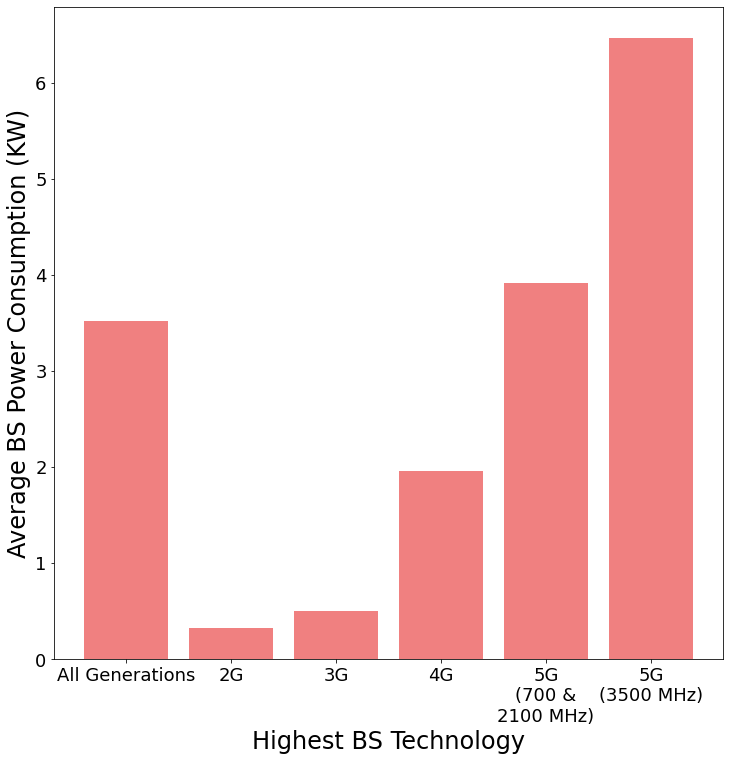

In [17]:
plot_avg_pw_per_highest_BS_tech_monthwise(dates, BS_avg_pw_main_opr, BS_avg_pw_H_2G, BS_avg_pw_H_3G, BS_avg_pw_H_4G, BS_avg_pw_H_5G, BS_avg_pw_H_5G_3500)

In [18]:
CAGR(dates, total_pw_main_opr, BS_avg_pw_main_opr)

BS Total Power CAGR: 0.18185507512487442
BS Total Power CAGR after 5G: 0.19749867027492063
BS Average Power CAGR: 0.09889358237958201
BS Average Power CAGR after 5G: 0.11704322529980526
--------------------------------------------------------
BS Average Power starting value: 1.7516856487253356
BS Average Power ending value: 3.5254168848858054
